# Swing on Strike

```python
#definitions
dfc["batter_div_with_vibe"] = (
    dfc["batter_divinity"] * dfc["batter_mul"] * (1 + 0.2 * dfc["batter_vibes"])
)
dfc["batter_musc_with_vibe"] = # similar to above
dfc["batter_thwack_with_vibe"] = # similar to above
dfc["invpath_with_vibe"] = ( # note the division and when it happens
    (1 - dfc["batter_patheticism"] / dfc["batter_mul"])
    * (1 + 0.2 * dfc["batter_vibes"])
)
dfc["combined_batting"] = 0.25 * (
    dfc["batter_div_with_vibe"]
    + dfc["batter_musc_with_vibe"]
    + dfc["invpath_with_vibe"]
    + dfc["batter_thwack_with_vibe"]
)  # essentially the average of the four

# the formula
dfc["threshold"] = (
    0.70
    + 0.35 * dfc["combined_batting"]
    - 0.40 * dfc["pitcher_ruth_with_vibe"]
    + 0.20 * (dfc["ballpark_viscosity"] - 0.5)
)
```
Works for Season 12 thru Season 15, if you avoid several problematic modifiers: `["O_NO", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "TRAVELING"].` Sutton Dreamy's Night Vision Goggles are also being *weird and inconsistent*, and don't always "work" either. There is one weird attractor-placed-in-secret-base roll (Tad Seeth, season 15) that we catch too, which needs to be sorted out (may have already been sorted out by the time you read this actually). But otherwise, this formula is rock-solid.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from csv_dtypes import column_dtypes

import load

In [46]:
season = 18
df = load.data("swing-on-strike", season=season)

df["ruth_vibes"] = load.player_attribute(df, 'pitcher', 'ruthlessness', vibes=True, mods=True, items=True, broken_items=True)

df["div_vibes"] = load.player_attribute(df, 'batter', 'divinity', vibes=True, mods=True, items=True, broken_items=True)
df["musc_vibes"] = load.player_attribute(df, 'batter', 'musclitude', vibes=True, mods=True, items=True, broken_items=True)
df["thwack_vibes"] = load.player_attribute(df, 'batter', 'thwackability', vibes=True, mods=True, items=True, broken_items=True)
df["path_scaled"] = load.player_attribute(df, 'batter', 'patheticism', vibes=False, mods=False, items="negative", broken_items=True)
# df["invpath_vibes"] = (1 - df["path_scaled"]) * (1 + 0.2 * df["batter_vibes"])

# center=True is the default
df["viscosity"] = load.stadium_attribute(df, 'viscosity', center=False)
print(len(df))

116835


In [47]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # sometimes traveling doesn't do anything on pitchers, but not always
        # if not row["top_of_inning"]:
            # mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        pass # sometimes growth doesn't do anything on pitchers, but not always
        # mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        pass
        if row["top_of_inning"]:
            mul += 0.03
    if "GROWTH" in btm:
        pass
        mul += min(0.03, 0.03 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    # if "SINKING_SHIP" in btm:
    #     mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        mul += 2.0
    if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        mul += 0.150
    return mul

In [206]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["invpath_vibes"] = (1 - (df["path_scaled"] / df["batter_mul"])) * (1 + 0.2 * df["batter_vibes"])

df["combined_batting"] = 0.25 * (
    df["div_vibes"]
    + df["musc_vibes"]
    + df["invpath_vibes"]
    + df["thwack_vibes"]
)



df["hypediff"] = df["batting_team_hype"] - df["pitching_team_hype"]
df["hypediff_bvibes"] = df["hypediff"] * (1 + 0.2 * df["batter_vibes"])
df["hypediff_pvibes"] = df["hypediff"] * (1 + 0.2 * df["pitcher_vibes"])

In [207]:
# df = df0.copy()
# df["batter_mul"] = df.apply(get_batter_mul, axis=1)
# df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

# # for attr in ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']:
# #     df[attr] = df[attr] * df['batter_mul']
# # for attr in ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']:
# #     df[attr] = df[attr] * df['pitcher_mul']

# # removed path and tragicness from this, because they're inverse attrs and need to be flipped first
# #     if attr in ['batter_divinity', 'batter_musclitude', 'batter_groundfriction']:
# #         df[df["batter_mods"].astype(str).str.contains("CHUNKY")][attr] = df[attr] * (df['batter_mul'] + 1.0)
# #         df[~df["batter_mods"].astype(str).str.contains("CHUNKY")][attr] = df[attr] * df['batter_mul']
# #     else:
# for attr in [
#     "batter_buoyancy",
#     "batter_divinity",
#     "batter_martyrdom",
#     "batter_moxie",
#     "batter_musclitude",
#     "batter_thwackability",
#     "batter_coldness",
#     "batter_overpowerment",
#     "batter_ruthlessness",
#     "batter_shakespearianism",
#     "batter_suppression",
#     "batter_unthwackability",
#     "batter_base_thirst",
#     "batter_continuation",
#     "batter_ground_friction",
#     "batter_indulgence",
#     "batter_laserlikeness",
#     "batter_anticapitalism",
#     "batter_chasiness",
#     "batter_omniscience",
#     "batter_tenaciousness",
#     "batter_watchfulness",
#     "batter_pressurization",
#     "batter_cinnamon",
# ]:
#     df[attr] = df[attr] * df["batter_mul"]
# for attr in [
#     "pitcher_buoyancy",
#     "pitcher_divinity",
#     "pitcher_martyrdom",
#     "pitcher_moxie",
#     "pitcher_musclitude",
#     "pitcher_thwackability",
#     "pitcher_ruthlessness",
#     "pitcher_overpowerment",
#     "pitcher_unthwackability",
#     "pitcher_shakespearianism",
#     "pitcher_suppression",
#     "pitcher_coldness",
#     "pitcher_base_thirst",
#     "pitcher_continuation",
#     "pitcher_ground_friction",
#     "pitcher_indulgence",
#     "pitcher_laserlikeness",
#     "pitcher_anticapitalism",
#     "pitcher_chasiness",
#     "pitcher_omniscience",
#     "pitcher_tenaciousness",
#     "pitcher_watchfulness",
#     "pitcher_pressurization",
#     "pitcher_cinnamon",
# ]:
#     df[attr] = df[attr] * df["pitcher_mul"]

# df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
# df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# df["pitcher_ruth_with_vibe"] = df["pitcher_ruthlessness"] * (1 + 0.2 * df["pitcher_vibes"])
# df["batter_moxie_with_vibe"] = df["batter_moxie"] * (1 + 0.2 * df["batter_vibes"])
# df["batter_musc_with_vibe"] = df["batter_musclitude"] * (1 + 0.2 * df["batter_vibes"])
# df["batter_thwack_with_vibe"] = df["batter_thwackability"] * (1 + 0.2 * df["batter_vibes"])
# df["batter_div_with_vibe"] = df["batter_divinity"] * (1 + 0.2 * df["batter_vibes"])

# df["ruth_times_vibe"] = df["pitcher_ruthlessness"] * df["pitcher_vibes"]
# df["moxie_times_vibe"] = df["batter_moxie"] * df["batter_vibes"]
# df["path_times_vibe"] = df["batter_patheticism"] * df["batter_vibes"]
# df["thwack_times_vibe"] = df["batter_thwackability"] * df["batter_vibes"]
# df["musc_times_vibe"] = df["batter_musclitude"] * df["batter_vibes"]
# df["div_times_vibe"] = df["batter_divinity"] * df["batter_vibes"]
# df["filth_times_visc"] = df["ballpark_filthiness"] * df["ballpark_viscosity"]


# df["invpath"] = 1 - df["batter_patheticism"] / df["batter_mul"]
# df["invpath_mul"] = df["invpath"]  # / df['batter_mul']
# df["invpath_with_vibe"] = df["invpath_mul"] * (1 + 0.2 * df["batter_vibes"])
# df["combined_batting"] = 0.25 * (
#     df["batter_div_with_vibe"]
#     + df["batter_musc_with_vibe"]
#     + df["invpath_with_vibe"]
#     + df["batter_thwack_with_vibe"]
# )


# # 'batter_div_with_vibe', 'batter_musc_with_vibe', 'invpath_with_vibe', 'batter_thwack_with_vibe',
# #         'pitcher_ruth_with_vibe', 'ballpark_viscosity'


# # df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [208]:
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "CHUNKY", "SMOOTH"]:
for exclude_mod in ["0", "O_NO", "LATE_TO_PARTY", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "MINIMALIST", "MAXIMALIST",
                    "SINKING_SHIP", "TRAVELING", "HIGH_PRESSURE", "OVERPERFORMING", "UNDERPERFORMING",]:
    # for exclude_mod in ["O_NO", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc = dfc[dfc["hypediff"] == 0]
# dfc = dfc[dfc['roll'] < 0.95]
# dfc = dfc[dfc['roll'] > 0.1]
# dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]
# dfc = dfc[(dfc['pitcher_vibes'].abs() < 0.2) & (dfc['batter_vibes'].abs() < 0.2)]
# dfc = dfc[dfc['batter_patheticism'] > 0.1]

len(dfc)

36001

In [223]:
# X = dfc[['roll', 'passed',
#         'batter_div_with_vibe', 'batter_musc_with_vibe', 'batter_patheticism', 'batter_thwack_with_vibe',
#         'pitcher_ruth_with_vibe', 'ballpark_viscosity']]
# X = dfc[['roll', 'passed',
#         'batter_div_with_vibe', 'batter_musc_with_vibe', 'invpath_with_vibe', 'batter_thwack_with_vibe',
#         'pitcher_ruth_with_vibe', 'ballpark_viscosity']]
X = dfc[
    [
        "roll",
        "passed",
        "combined_batting",
        "ruth_vibes",
        "viscosity",
        # "batting_team_hype",
        # "pitching_team_hype",
        "hypediff_bvibes",
        "hypediff_pvibes",
    ]
]
# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop("passed", axis=1)


pin_intercept = None
pin_intercept = 0.5
pins = [
    (-0.20, "ruth_vibes"),
    (0.20, "viscosity"),
    (0.35, "combined_batting"),
    (0.07, "hypediff_bvibes"),
    (0.04, "hypediff_pvibes"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X.shape)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(f"score: {trainedsvm.score(X2, y)} ({len(X2) - sum(np.diag(confusion_matrix(y, predictionsvm)))} outliers)")

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

(36001, 1)
[[11427     0]
 [    0 24574]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     11427
        True       1.00      1.00      1.00     24574

    accuracy                           1.00     36001
   macro avg       1.00      1.00      1.00     36001
weighted avg       1.00      1.00      1.00     36001

score: 1.0 (0 outliers)
0.5 , intercept
(-0.2, 'ruth_vibes')
(0.2, 'viscosity')
(0.35, 'combined_batting')
(0.07, 'hypediff_bvibes')
(0.04, 'hypediff_pvibes')


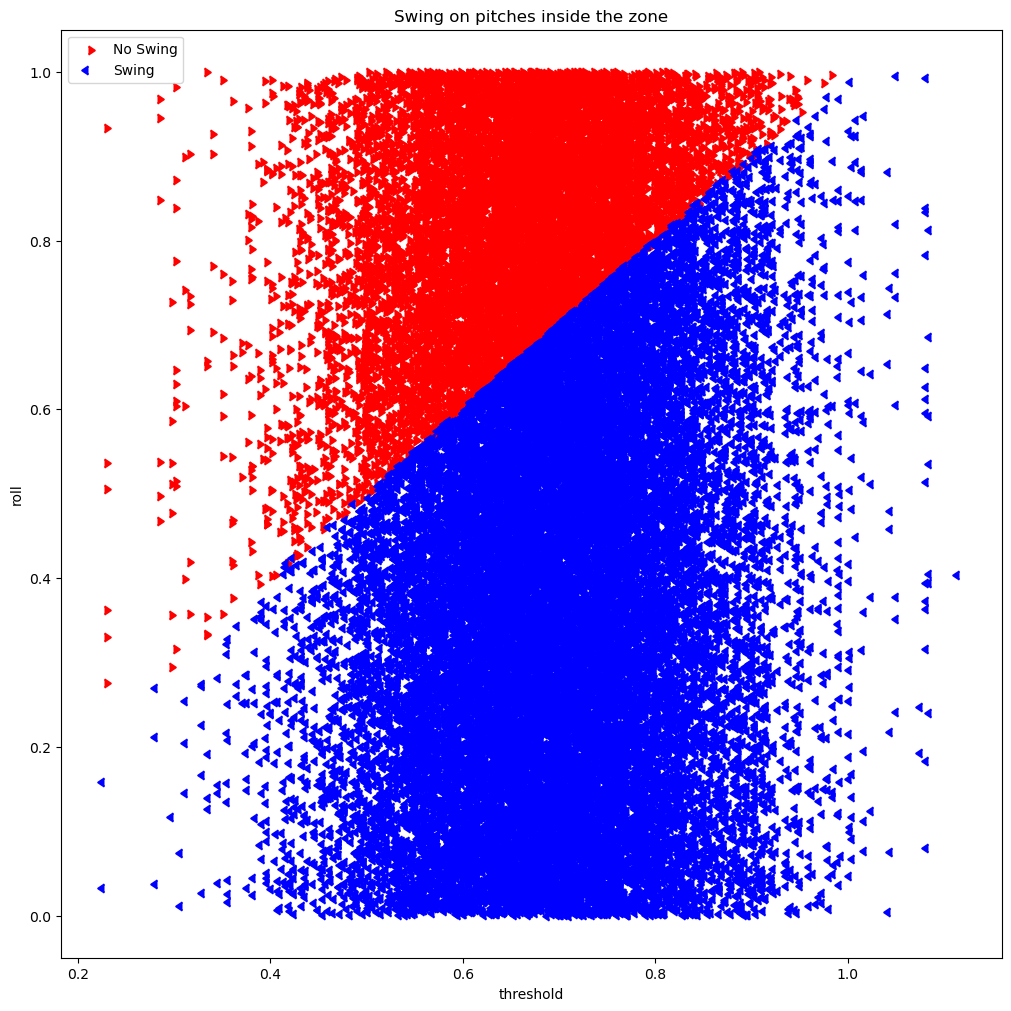

In [220]:
dfc["threshold"] = (
    0.50
    + 0.35 * dfc["combined_batting"]
    - 0.20 * dfc["ruth_vibes"]
    + 0.20 * (dfc["viscosity"])
    + 0.07 * dfc["hypediff_bvibes"]
    + 0.04 * dfc["hypediff_pvibes"]
)

# intercept = intercept_scaled
# dfc['threshold'] = intercept_scaled
# print(intercept_scaled)
# for pair in pins + list(zip(-np.array(coef_list), X.columns)):
#     if "roll" not in pair[1]:
#         print(pair)
#         dfc['threshold'] += pair[0] * dfc[pair[1]]
# dfc["svc"] = dfc["threshold"] - intercept_scaled



x_val = "threshold"
# x_val = "invpath_with_vibe"
fig, ax = plt.subplots(1, figsize=(10, 10), layout="constrained")
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="No Swing",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Swing",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Swing on pitches inside the zone")
# ax.set_xlim(0.484, 0.499)

ax.legend()

0


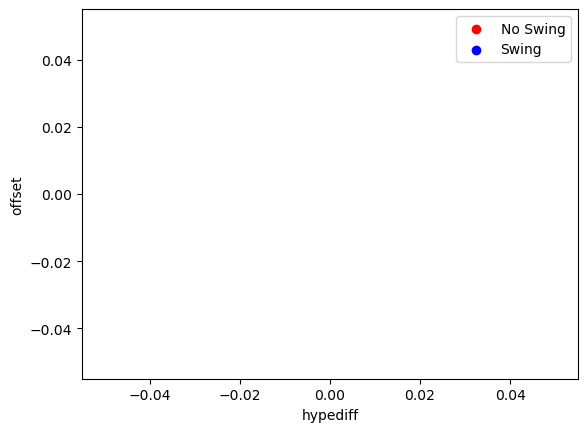

In [221]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "hypediff"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Swing",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Swing",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
print(len(table))
table = table[
    [
        "event_type",
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        "roll",
        "threshold",
        # "pitcher_mul",
        # "batter_mul",
        "baserunner_count",
        #        "batter_vibes", "pitcher_vibes",
        "ruth_vibes",
        "invpath_vibes",
        "viscosity",
        # "batter_musclitude", "batter_divinity", "batter_thwackability", "batter_patheticism",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
    ]
].sort_values("offset", ascending=False)
# len(table)
# print(table['offset']/table['threshold'])
# table

In [222]:
print(table.groupby("pitching_team_mods").size())
print(table.groupby("batting_team_mods").size())
print(table.groupby("batter_mods").size())
print(table.groupby("pitcher_mods").size())

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


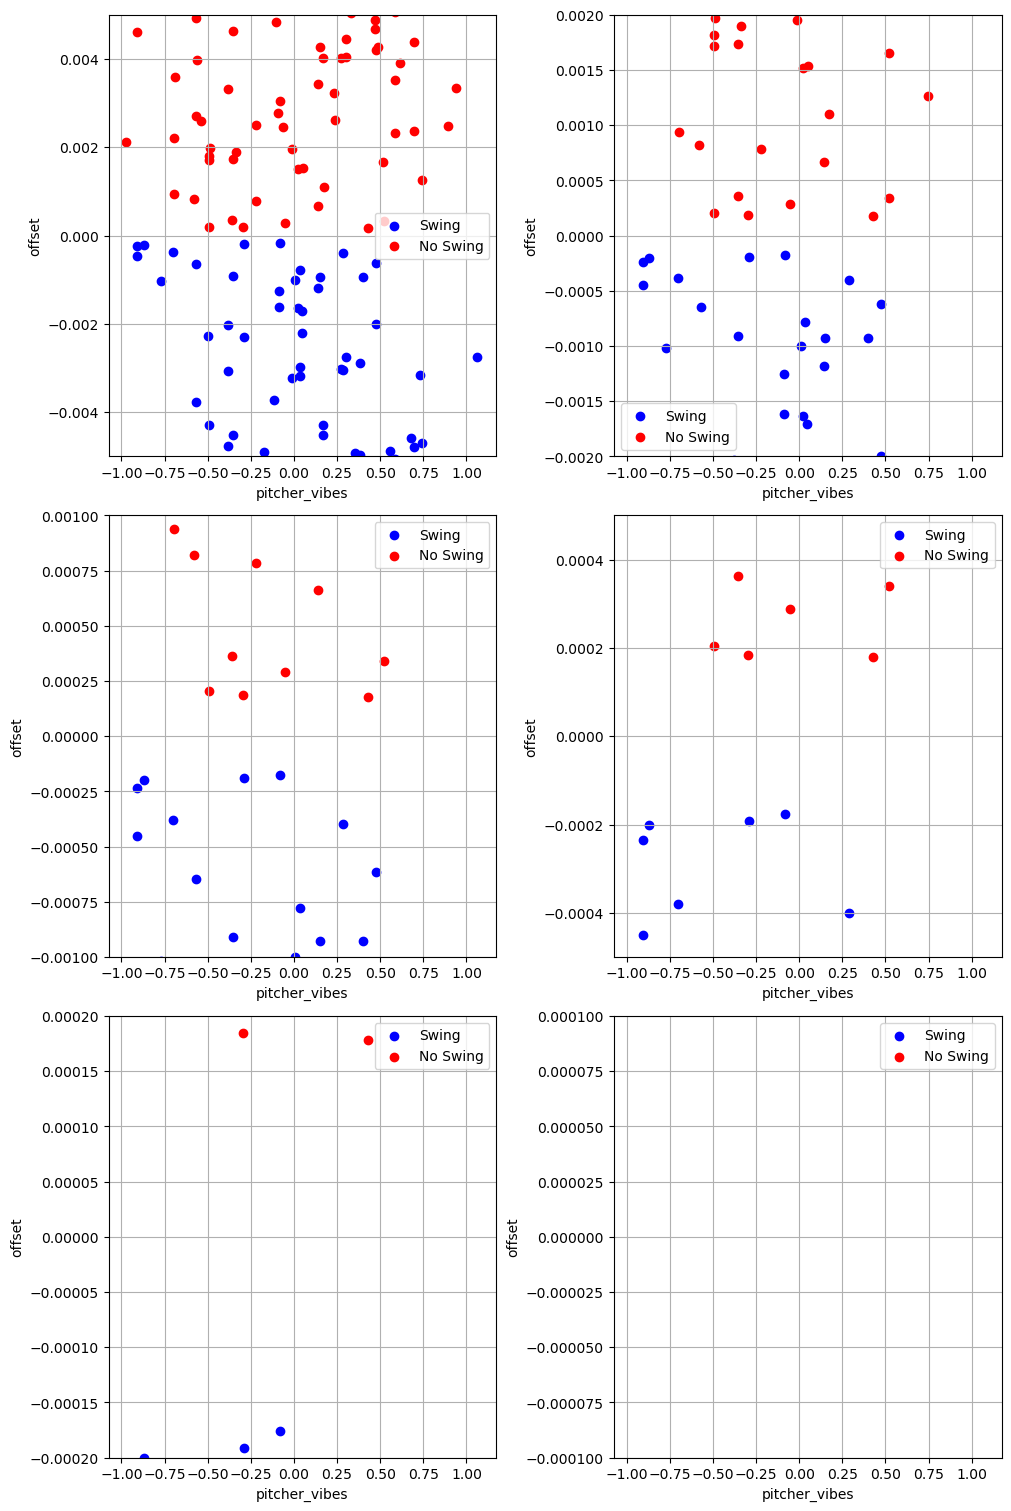

In [192]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15), layout="constrained")
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Swing",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Swing",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="yellow",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="yellow",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    # ax.set_yscale("log")
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/swing_strike_fit_offsets.png", facecolor='white')

In [22]:
# list(df.columns)